In [582]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade seaborn
!pip install --upgrade contractions
!pip install --upgrade wordcloud
!pip install --upgrade umap-learn
!pip install --upgrade gensim
!pip install --upgrade pyldavis
#!pip install pattern

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: contractions in c:\anaconda\lib\site-packages (0.0.17)
Requirement already up-to-date: wordcloud in c:\anaconda\lib\site-packages (1.5.0)
Requirement already up-to-date: umap-learn in c:\anaconda\lib\site-packages (0.3.7)
Requirement already up-to-date: gensim in c:\anaconda\lib\site-packages (3.7.0)
Requirement already up-to-date: pyldavis in c:\anaconda\lib\site-packages (2.1.2)


In [583]:
#hdbscan test, not working import, what to do?
'''!pip install --upgrade PyHamcrest
!pip install --upgrade setuptools
!pip install --upgrade cython
!pip install --upgrade hdbscan
import setuptools
import cython
import hdbscan''';

In [584]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob
import contractions
from wordcloud import WordCloud
import umap
import unicodedata
from bs4 import BeautifulSoup
from time import time
from itertools import compress

#from scipy import interp
sns.set(font_scale=1.3)

%matplotlib inline

In [951]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import recall_score, brier_score_loss,precision_score,f1_score
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS


from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
#from gensim.utils import lemmatize as gensim_lemmatizer

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim

#import pattern

In [586]:
#npl libs
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [587]:
high_level_cat = ['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']

In [588]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

!describe dataset

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [589]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [590]:
newsgroups_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [591]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

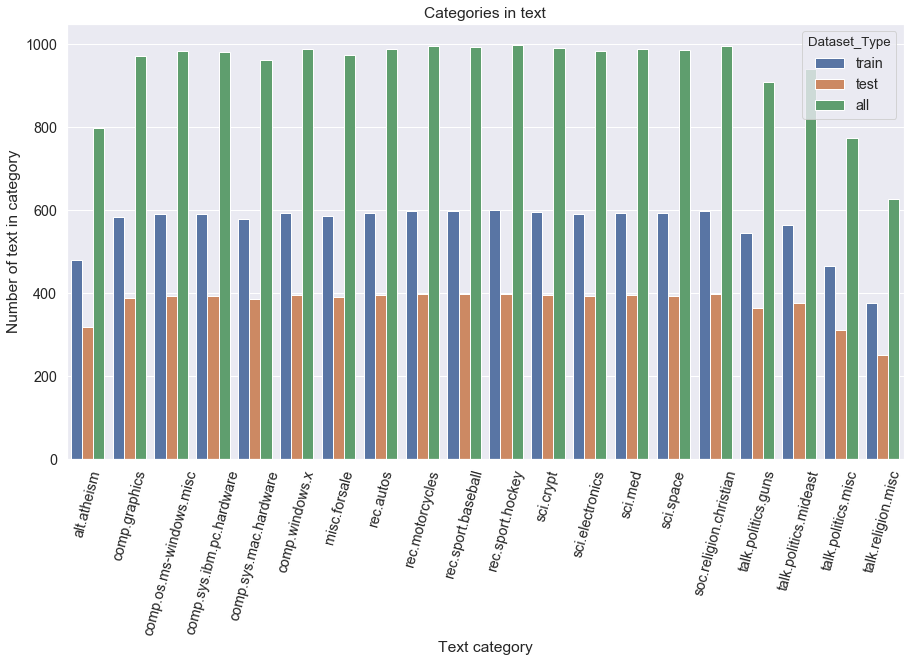

In [592]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


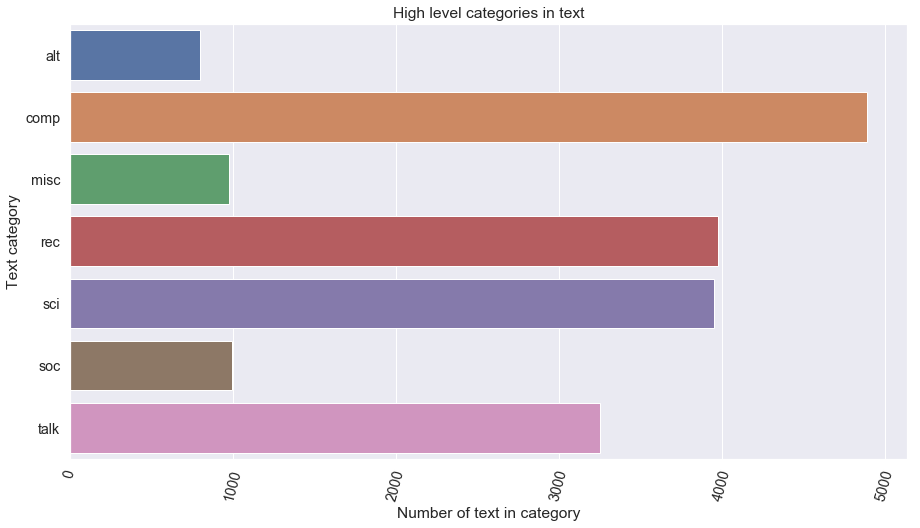

In [593]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Посмотрим на образец данных.

In [594]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [595]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [596]:
pprint(newsgroups_all.data[39])

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [597]:
newsgroups_all.target_names[newsgroups_all.target[39]]

'talk.religion.misc'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие 'шумовые' элементы.

#### Data preprocessing.

Предобработаем данные, для этого:
- оставим только верхние категории текстов.

Созданим токенайзер, который будет:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [598]:
#backup
'''def preprocess_categories(text):
    #unique, counts = np.unique(text.target, return_counts=True)
    df_texts = pd.DataFrame(data=list(zip(text.data, text.target)),columns = ['data','category'])
    #remake this into better code!
    for i in df_texts.index:
        df_texts.ix[i, 'category'] = newsgroups_all.target_names[df_texts.at[i, 'category']];
        
    df_texts['target'] = df_texts["category"].str.split(".", expand = True)[0]
    
    df_texts.drop('category',inplace = True, axis = 1)

    return df_texts''';

In [599]:
#modifyied
def preprocess_categories(text):
    #unique, counts = np.unique(text.target, return_counts=True)
    df_texts = pd.DataFrame(data=list(zip(text.data, text.target)),columns = ['data','category'])
    #remake this into better code!
    for i in df_texts.index:
        df_texts.loc[i, 'category'] = newsgroups_all.target_names[df_texts.at[i, 'category']];
        
    df_texts['target'] = df_texts["category"].str.split(".", expand = True)[0]
    
    df_texts.drop('category',inplace = True, axis = 1)

    return df_texts

In [600]:
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

In [601]:
train_texts = preprocess_categories(train_texts);
test_texts = preprocess_categories(test_texts);

In [602]:
train_texts.shape

(11314, 2)

In [603]:
test_texts.shape

(7532, 2)

##### Tokenizer.

In [988]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text

#'\\nRevision: (\d+)\\n'
#r'\nRevision: (\d+)\n'

In [989]:
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text


def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [990]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (1) #do nothing
            else:
                new_word = p.number_to_words(word,group=2)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [991]:
def lemmatize_stemm_text2(text):
    new_text_lemma = []
    for wd in gensim_lemmatizer(str(text)):
        new_text_lemma.append(wd.decode('utf-8').split('/')[0])
        
    return new_text_lemma, _

In [992]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [1142]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie']

StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) 

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [1143]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [1144]:
#replace contractions in string of text
def replace_contractions(text):
    return contractions.fix(text)

In [1145]:
#remove html constructions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [1146]:
#remove non-ASCII characters from list of tokenized words"""
def remove_non_ascii(words):

    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [1147]:
# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    #remove html 
    text = strip_html(text)
    
    # text to lowercase
    text =  text.lower()
    
    # test it
    text = replace_contractions(text)
    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove non ascii? test it
    words = remove_non_ascii(words)
    
    #replace digits with words
    #words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

In [1148]:
%%time
test = tokenize(test_texts.data[4])

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 2 ms


In [1149]:
test

[]

Похоже, часть текста после отсечения стоп слов и очистки текстов может обнулиться. Это следует учесть при извлечении фич из текста.

Проверим работу токенайзера на других текстах.

In [1150]:
pprint(newsgroups_all.data[10:15]) #1,3,55,39

['From: Center for Policy Research <cpr>\n'
 'Subject: Zionism - racism\n'
 '\n'
 '\n'
 "Diaspora 'a cancer'\n"
 '------------------- by Julian Kossoff and Lindsay Schusman in:\n'
 'Jewish Chronicle, London, 22. Dec. 1989\n'
 '\n'
 'Leading Israeli author and cultural commentator, A.B. Yehoshua,\n'
 'launched a ferocious attack on diaspora Jewry at a Zionist Youth\n'
 'Council meeting in North London, last week.\n'
 '\n'
 'The diaspora, he claimed, "was the cancer connected to the main\n'
 'tissue of the Jewish people". He was scathing about its failure to\n'
 'act before the Holocaust.\n'
 '\n'
 "He said the diaspora's religious and secular leadership had\n"
 'ignored the warning signs in the 1920s, and had fiercely opposed\n'
 'Zionism. Consequently, he considered the Holocaust, "the failure\n'
 'of Judaism".\n'
 '\n'
 'His talk, entitled "Diaspora: A Neurotic Solution", covered 5,000\n'
 'years of Jewish history.\n'
 '\n'
 "Mr. Yehoshua's other targets included Soviet Jews who were,

In [1151]:
%%time
test0 = tokenize(newsgroups_all.data[1])
test = tokenize(newsgroups_all.data[10])
test2 = tokenize(newsgroups_all.data[13])
test4 = tokenize(newsgroups_all.data[44])
test5 = tokenize(newsgroups_all.data[55])
test6 = tokenize(newsgroups_all.data[66])
test7 = tokenize(newsgroups_all.data[77])

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 89.8 ms


In [1152]:
test0,test,test2, test4, test6, test7,test5

(['gamma',
  'ray',
  'burster',
  'extragalactic',
  'absorption',
  'galaxy',
  'expected',
  'transparent',
  'galactic',
  'core',
  'gamma',
  'ray',
  'later',
  'law',
  'incorrect',
  'assume',
  'unknown',
  'material',
  'dark',
  'matter',
  'inhibits',
  'gamma',
  'ray',
  'propagation',
  'possible',
  'actually',
  'seeing',
  'energetic',
  'event',
  'happening',
  'closer',
  'distribution',
  'caused',
  'characteristic',
  'propagation',
  'distance',
  'gamma',
  'ray',
  'shorter',
  'thickness',
  'disk',
  'galaxy',
  'maybe',
  'zero',
  'little',
  'typical',
  'energy',
  'gamma',
  'ray',
  'galaxy',
  'effectively',
  'transparent',
  'han',
  'bloemen',
  'review',
  'article',
  'ann',
  'rev',
  'astr',
  'astrophys',
  'year',
  'discus',
  'depth'],
 ['center',
  'policy',
  'research',
  'subject',
  'zionism',
  'racism',
  'diaspora',
  'cancer',
  'julian',
  'kossoff',
  'lindsay',
  'schusman',
  'jewish',
  'chronicle',
  'london',
  '22',
  'de

#### Classification. Apriory knoweledge.

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

In [1265]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             ngram_range= (1, 3)
                            )

In [1266]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 2min 34s


В силу того, что после извлечения фич могут получиться пустые тексты (например из-за отсечения стоп слов, по длине слова и т.д.), то есть смысл эти строки отфильтровать, чтобы улучшить качество классификации.

In [1267]:
def get_empty_rows(sprs_matrix):
    #list_ind = []
    empty_indecies_marker = sprs_matrix.getnnz(1)>0
    '''for i in range(len(empty_indecies_marker)):
        if empty_indecies_marker[i] == False:
            list_ind.append(i)'''
    
    return empty_indecies_marker

Также не стоит забывать про обновление массивов с метками классов, для этого сохраним их индексы.

In [1268]:
ind_train_to_drop = get_empty_rows(vectorised_train_documents)
ind_test_to_drop = get_empty_rows(vectorised_test_documents)

In [1269]:
vectorised_train_documents.shape #before

(11314, 39571)

In [1270]:
vectorised_test_documents.shape #before

(7532, 39571)

In [1271]:
#vectorised_test_documents.sum(axis=1)
vectorised_train_documents = vectorised_train_documents[vectorised_train_documents.getnnz(1)>0]
vectorised_test_documents = vectorised_test_documents[vectorised_test_documents.getnnz(1)>0]

In [1272]:
vectorised_train_documents.shape #after!

(10977, 39571)

In [1273]:
vectorised_test_documents.shape #after!

(7290, 39571)

In [1274]:
len(vectorizer.get_feature_names())

39571

Как видно, такие строки были и не в единичном количестве.

Выделим метки для трейн/тест датасетов.

In [1275]:
y_train, y_test = train_texts.target, test_texts.target

In [1276]:
len(y_train)

11314

In [1277]:
len(y_test)

7532

Также обновим метки классов, после удаления пустых строк, оставшихся после векторизации.

In [1278]:
#y_train
y_train = list(compress(y_train, ind_train_to_drop))
y_test = list(compress(y_test, ind_test_to_drop))

In [1279]:
len(y_train)

10977

In [1280]:
len(y_test)

7290

Дополним код вспомогательными функциями, которые будет производить:
- построение матрицы классификации.
- обучение и проверку работы классификатора, с заданными параметрами.

In [1281]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [1282]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

Для удобства, результирующие метрики будем сохранять в df.

In [1283]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score', 'parameters'))

In [1284]:
#variant with pipeline and cv
#takes a long time
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score':c, 'parameters':d},ignore_index=True)
    
    ''';

Проверим работу алгоритмов:
- MultinomialNB

In [1285]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01, 2, 5]
 
for alph in tqdm(alphas):
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [00:04<00:00, 11.89it/s]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:04<00:00, 11.74it/s]


In [1286]:
print(
results_df.iloc[results_df[results_df.Algorithm =='MultinomialNB']['Test_score'].idxmax()]
)

Algorithm      MultinomialNB
Train_score         0.968665
Test_score          0.817018
parameters      alpha = 0.02
Name: 5, dtype: object


- BernoulliNB

In [61]:
for alph in tqdm(alphas):
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|██████████████████████████████████████████| 51/51 [00:03<00:00, 14.29it/s]


Для проверки результатов выведем classification_report и построим матрицу классификации.

- LinearSVC

In [1175]:
%%time
linear_svc = LinearSVC(random_state=seed,max_iter = 10e3,class_weight = 'balanced',loss = 'squared_hinge',dual=False)
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.9, 1.0, 2.0, 5.0, 10.0]
penalties = ['l2']#,'l1']

for pn in tqdm(penalties):
    linear_svc.penalty  = pn
    for c in tqdm(C_values):
        f_el = "LinearSVC"
        linear_svc.C = c
        s_el,t_el,_ = classify_and_score(linear_svc, vectorised_train_documents, 
                               vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " penalty = " + pn

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 20.8 s


- SVC Kernel Poly

Известно, что метод опорных векторов чувствителен к выбору ядра и их параметров, то действовать скорее всего буду следующим образом, запуск алгоритма с дефолтными параметрами и если скор низкий, переходить к другому ядру.

Т.к. алгоритм требует достаточно большое время на выполнение, то ограничим перебор несколькими значениями параметра С.

In [1074]:
%%time

svc_poly = SVC(kernel='poly',gamma='scale',random_state=seed,class_weight = 'balanced')

svc_poly.C = 0.5
svc_poly.kernel = 'poly'
f_el = "SVC_" + svc_poly.kernel
s_el,t_el,_ = classify_and_score(svc_poly,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_poly.C) + " Kernel = " + svc_poly.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

'''
#C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]
C_values_reduced = [0.001, 0.01, 0.5]

for c in tqdm(C_values_reduced):
    f_el = "SVC_poly"
    svc_poly.C = c
    s_el,t_el,_ = classify_and_score(svc_poly, vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 6min 34s


- SVC Kernel Sigmoid and RBF

In [64]:
%%time

svc_k = SVC(kernel='sigmoid',gamma='scale',random_state=seed,class_weight = 'balanced',verbose=True)

svc_k.C = 0.5
svc_k.kernel = 'sigmoid'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)


svc_k.C = 0.5
svc_k.kernel = 'rbf'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

'''
kernels = ['rbf','sigmoid']
C_values_reduced = [0.001, 0.01, 0.5, 1.0, 5.0]

for kern in tqdm(kernels):
    svc_k.kernel = kern
    for c in tqdm(C_values_reduced):
        svc_k.C = c
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''

[LibSVM]

D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[LibSVM]

D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Wall time: 5min 3s


- SGDClassifier.

In [1071]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'l2',
                        alpha = 0.0001, l1_ratio = 0.01,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [1072]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]

for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


Как видно из результатов, лучше всего работает функция потерь:

In [948]:
sgd_clf.loss = 'modified_huber'
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=100, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=321, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

Попробуем подобрать для нее оптимальный параметр регуляризации:

In [949]:
for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    f_el = "SGD"
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents,
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alp)
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 50%|██████████████████████████████████████████                                          | 4/8 [00:07<00:07,  1.80s/it]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:08<00:05,  1.77s/it]C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-

In [70]:
#attempt of elastic net

'''alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]

for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)''';
# compare hinge loss == linear SVM
# compare other different kernels

Возвращаем обратно параметр alpha.

In [71]:
sgd_clf.alpha = 0.0001
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=100, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=321, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возрастает и приводит к тому, что массив не помещяется в память.

In [72]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";

Попробуем визуализировать скор алгоритмов, для того, чтобы визуально оценить их работу.

In [73]:
#sns.lineplot(x=results_df.Test_score, hue="Algorithm", lw=1, data=results_df)
#ax = sns.lineplot(y = 'Test_score',data = results_df)
#sns.lineplot(x = results_df.Test_score,data = results_df)
#plt.plot(results_df[results_df.Algorithm == 'SVC_poly']['Test_score'])

In [852]:
def get_top_n_words(clf, vectorizer, n):
    # improve for most not used words too
    for cls in range(len(clf.coef_)):
        print (cls, labels[cls])
        neg_class_prob_sorted = clf.coef_[cls, :].argsort()[::1] #1 ascending order #-1 descending order
        pos_class_prob_sorted = clf.coef_[cls, :].argsort()[::-1] 
        print ("most informative features")
        print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:n]))
        print ("less informative features")
        print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:n]))

Выведем 3 алгоритма с наилучшими результатами.

In [1176]:
print(
results_df.iloc[results_df[results_df.Algorithm =='MultinomialNB']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='LinearSVC']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='SGD']['Test_score'].idxmax()]
)

Algorithm      MultinomialNB
Train_score         0.968665
Test_score          0.817018
parameters      alpha = 0.02
Name: 5, dtype: object 
 Algorithm                 LinearSVC
Train_score                0.990815
Test_score                 0.819286
parameters     C = 0.5 penalty = l2
Name: 57, dtype: object 



Выведем матрицу классификации и топ слов для каждого из этих алгоритмов.

##### MultinomialNB.

              precision    recall  f1-score   support

         alt       0.75      0.37      0.49       310
        comp       0.86      0.91      0.88      1906
        misc       0.87      0.68      0.76       382
         rec       0.88      0.89      0.89      1523
         sci       0.81      0.77      0.79      1518
         soc       0.72      0.78      0.75       384
        talk       0.74      0.82      0.78      1267

   micro avg       0.82      0.82      0.82      7290
   macro avg       0.80      0.75      0.76      7290
weighted avg       0.82      0.82      0.82      7290

Confusion matrix, without normalization
None


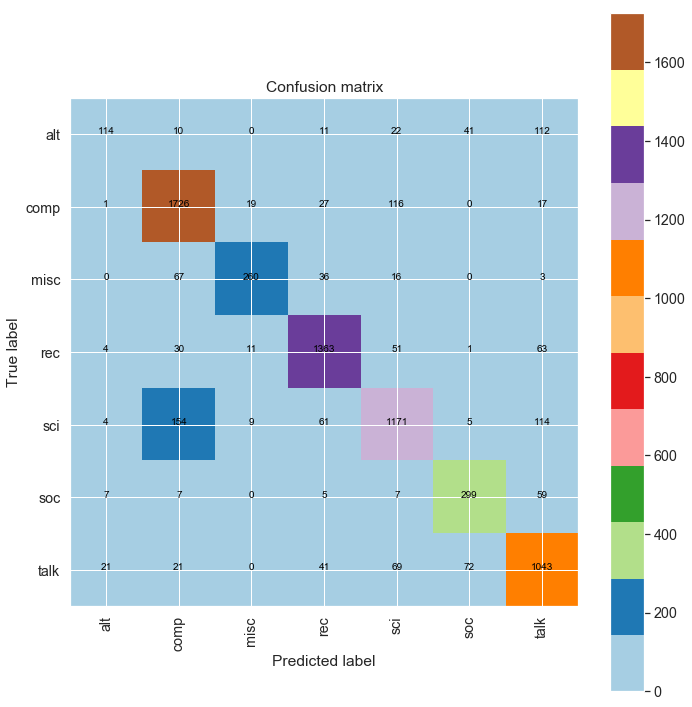

In [1287]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.04), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))


In [1288]:
get_top_n_words(clf,vectorizer,10)

0 alt
most informative features
['god' 'religion' 'people' 'think' 'say' 'atheist' 'atheism' 'thing'
 'islam' 'argument']
less informative features
['00' 'octopus' 'october 1992' 'october 1991' 'octal' 'oct' 'ocr'
 'occurring' 'occuring' 'occurance']
1 comp
most informative features
['window' 'thanks' 'file' 'problem' 'use' 'know' 'card' 'drive' 'program'
 'work']
less informative features
['know belief' 'karabakhi armenian lived' 'karabakhi armenian' 'karabakhi'
 'karabakh conflict azerbaijan' 'karabakh conflict' 'karabakh'
 'karabagh armenian' 'karabagh' 'karabag province search']
2 misc
most informative features
['sale' 'offer' 'shipping' 'condition' 'new' 'sell' '00' 'price' 'email'
 'interested']
less informative features
['know belief' 'order 100' 'ordeal' 'ordained' 'orchid fahrenheit 1280'
 'orchid fahrenheit' 'orchestrated' 'orbiting satellite' 'orbiting'
 'orbiter']
3 rec
most informative features
['game' 'car' 'team' 'year' 'like' 'bike' 'think' 'player' 'good' 'know']
less 

##### SGD Classifier.

In [78]:
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=100, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=321, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
_,_,clf =  classify_and_score(sgd_clf, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

              precision    recall  f1-score   support

         alt       0.44      0.48      0.46       310
        comp       0.87      0.89      0.88      1906
        misc       0.71      0.79      0.75       382
         rec       0.87      0.87      0.87      1521
         sci       0.83      0.75      0.78      1518
         soc       0.59      0.78      0.67       384
        talk       0.78      0.73      0.75      1267

   micro avg       0.80      0.80      0.80      7288
   macro avg       0.73      0.76      0.74      7288
weighted avg       0.80      0.80      0.80      7288

Confusion matrix, without normalization
None


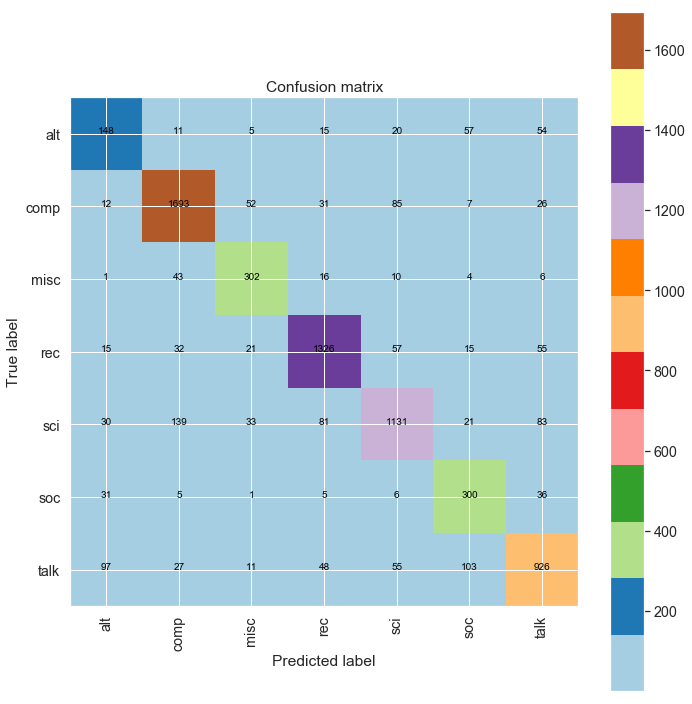

In [80]:
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

In [81]:
get_top_n_words(clf, vectorizer, 10)

0 alt
most informative features
['motto' 'atheism' 'nanci' 'religion' 'enlighten' 'loan' 'bsa' 'bobby'
 'islamic' 'cruel']
less informative features
['christians' 'christ' 'scripture' 'want' 'play' 'truth' 'order' 'judaism'
 'heaven' 'christian']
1 comp
most informative features
['windows' 'graphics' 'mac' 'apple' 'problem' 'window' 'image' 'motif'
 'file' 'widget']
less informative features
['sale' 'offer' 'circuit' 'car' 'pgp' 'sell' 'brand' 'ship' 'items'
 'condition']
2 misc
most informative features
['sale' 'ship' 'offer' 'headline' 'forsale' 'tracy' 'sell' 'new'
 'refrigerator' 'miller']
less informative features
['help' 'wonder' 'appreciate' 'dealer' 'comment' 'remember' 'data'
 'problem' 'saw' 'question']
3 rec
most informative features
['bike' 'car' 'motorcycle' 'team' 'dod' 'cars' 'hockey' 'helmet'
 'baseball' 'sport']
less informative features
['gun' 'work' 'space' 'offer' 'cassette' 'health' 'government' 'use'
 'computer' 'house']
4 sci
most informative features
['space' 'c

#### Linear SVC.

In [82]:
linear_svc = LinearSVC(random_state=seed,max_iter = 10e3,class_weight = 'balanced',loss = 'squared_hinge',dual=False)
linear_svc.penalty  = 'l2'
linear_svc.C = 0.2

In [83]:
linear_svc

LinearSVC(C=0.4, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000.0,
     multi_class='ovr', penalty='l2', random_state=321, tol=0.0001,
     verbose=0)

In [84]:
_,_,clf =  classify_and_score(linear_svc, vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

              precision    recall  f1-score   support

         alt       0.49      0.48      0.48       310
        comp       0.88      0.89      0.88      1906
        misc       0.76      0.79      0.77       382
         rec       0.87      0.88      0.87      1521
         sci       0.82      0.76      0.79      1518
         soc       0.64      0.78      0.71       384
        talk       0.78      0.75      0.77      1267

   micro avg       0.81      0.81      0.81      7288
   macro avg       0.75      0.76      0.75      7288
weighted avg       0.81      0.81      0.81      7288

Confusion matrix, without normalization
None


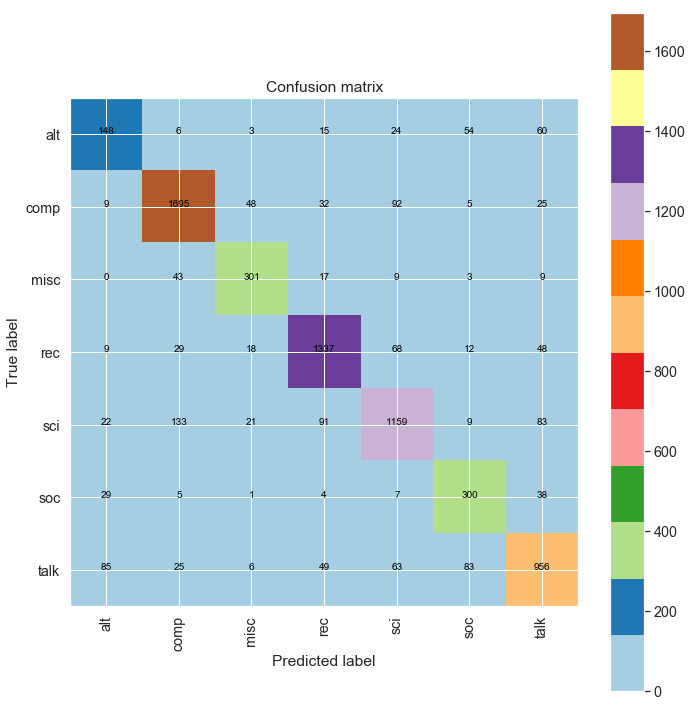

In [85]:
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))

In [86]:
get_top_n_words(clf, vectorizer, 10)

0 alt
most informative features
['atheism' 'motto' 'religion' 'bobby' 'nanci' 'islamic' 'islam' 'atheists'
 'deletion' 'loan']
less informative features
['christians' 'christ' 'scripture' 'want' 'order' 'heaven' 'judaism'
 'children' 'friend' 'christian']
1 comp
most informative features
['windows' 'graphics' 'mac' 'motif' 'problem' 'apple' 'image' 'file'
 'window' 'powerbook']
less informative features
['sale' 'offer' 'car' 'circuit' 'pgp' 'manuals' 'game' 'sell' 'years'
 'team']
2 misc
most informative features
['sale' 'offer' 'ship' 'sell' 'include' 'forsale' 'condition' 'summer'
 'headline' 'postage']
less informative features
['help' 'read' 'appreciate' 'hear' 'tell' 'wonder' 'program' 'connect'
 'problem' 'remember']
3 rec
most informative features
['car' 'bike' 'team' 'motorcycle' 'dod' 'cars' 'hockey' 'helmet'
 'baseball' 'players']
less informative features
['gun' 'space' 'offer' 'government' 'use' 'card' 'work' 'program' 'file'
 'house']
4 sci
most informative features
['spac

Заключение.
Наилучшим классфикатором в этой задачи является LinearSVC.
Хотя разрыв между топ-3 классификаторами является достаточно малым.

Также стоит выделить, что...

In [87]:
#backup results
#results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

#### Classfication. Without apriory knoweledge.

В этом разделе попробуем классифицировать объекты без знания о принадлежности текстов к какому-либо классу.
Для этого:
- попробуем посмотреть на тексты без знания(EDA), об их принадлежности классам.
- сократим размерность (TruncatedSVD)  и попробуем визуализировать структуру данных (T-SNE or UMAP).  
- Попробуем выделить классы при помощи K-means or MiniBatchKMeans;DBSCAN or HDBSCANС.

#### EDA.
Для того, чтобы оценить как-то текст, без знания меток классов:
- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.
- сколько слов во всех текстах, среднее число слов на 1 текст.
- выделим топ-20 слов по всем текстам и построим их гистограмму частот.
- построим облако слов. (по мнению CountVectorizer и TfIdfVectorizer).


- построим гистограмму: количество слов - длина слова
- Еще график с зависимостью количества слов от его длины./просто посчитать символ-частота?


- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.

In [88]:
print (len(train_texts.data),';',len(test_texts.data))

11314 ; 7532


In [1291]:
df_texts = pd.DataFrame(data=train_texts.data.values,columns = ['text'])#, 'text_type'])

df_texts['text_type'] = 'train'

df_texts = df_texts.append(pd.DataFrame(data=test_texts.data.values,columns = ['text']), ignore_index=True,sort=False)

df_texts.fillna(value='test',inplace=True)

df_texts['text_len'] = df_texts.text.str.len()

df_texts['n_words'] = df_texts.text.str.split()

df_texts['n_words'] = df_texts.n_words.str.len()

print (pd.concat([df_texts[df_texts.text_type == 'train'].describe(),
                  df_texts[df_texts.text_type == 'test'].describe()], axis=1))

# count words in train
df_texts[df_texts.text_type == 'train'].n_words.sum()
# count words in test
df_texts[df_texts.text_type == 'test'].n_words.sum()

           text_len       n_words       text_len      n_words
count  11314.000000  11314.000000    7532.000000  7532.000000
mean    1218.135496    185.827382    1096.862586   175.344397
std     4038.256477    523.971647    3571.221784   465.226887
min        0.000000      0.000000       0.000000     0.000000
25%      237.000000     40.000000     230.000000    39.000000
50%      491.000000     83.000000     483.500000    82.000000
75%      984.750000    167.000000     967.250000   163.000000
max    74878.000000  11765.000000  158791.000000  9507.000000


1320694

D:\Programs\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


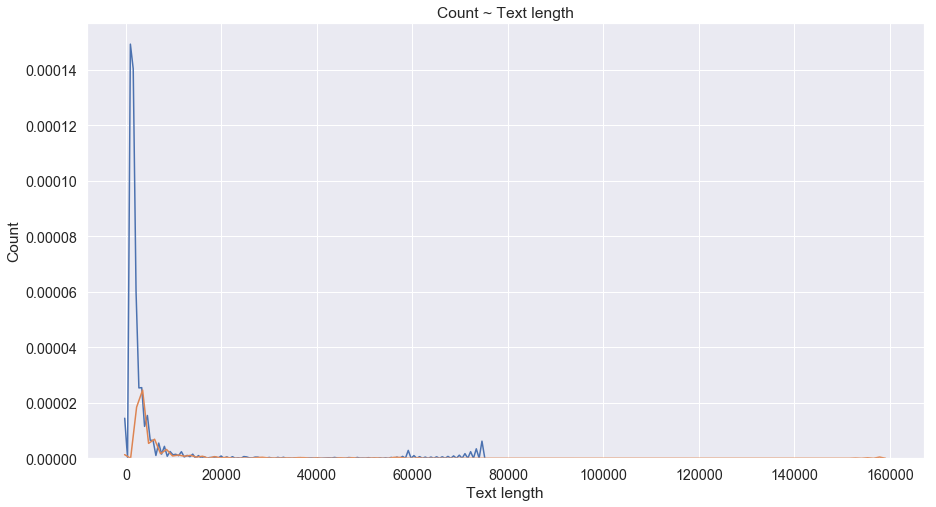

In [90]:
plt.figure(figsize=(15,8))
sns.distplot(df_texts[df_texts.text_type == 'train'].text_len,hist = False)
sns.distplot(df_texts[df_texts.text_type == 'test'].text_len,hist = False)
plt.xlabel('Text length');
plt.ylabel('Count');
plt.title("Count ~ Text length");

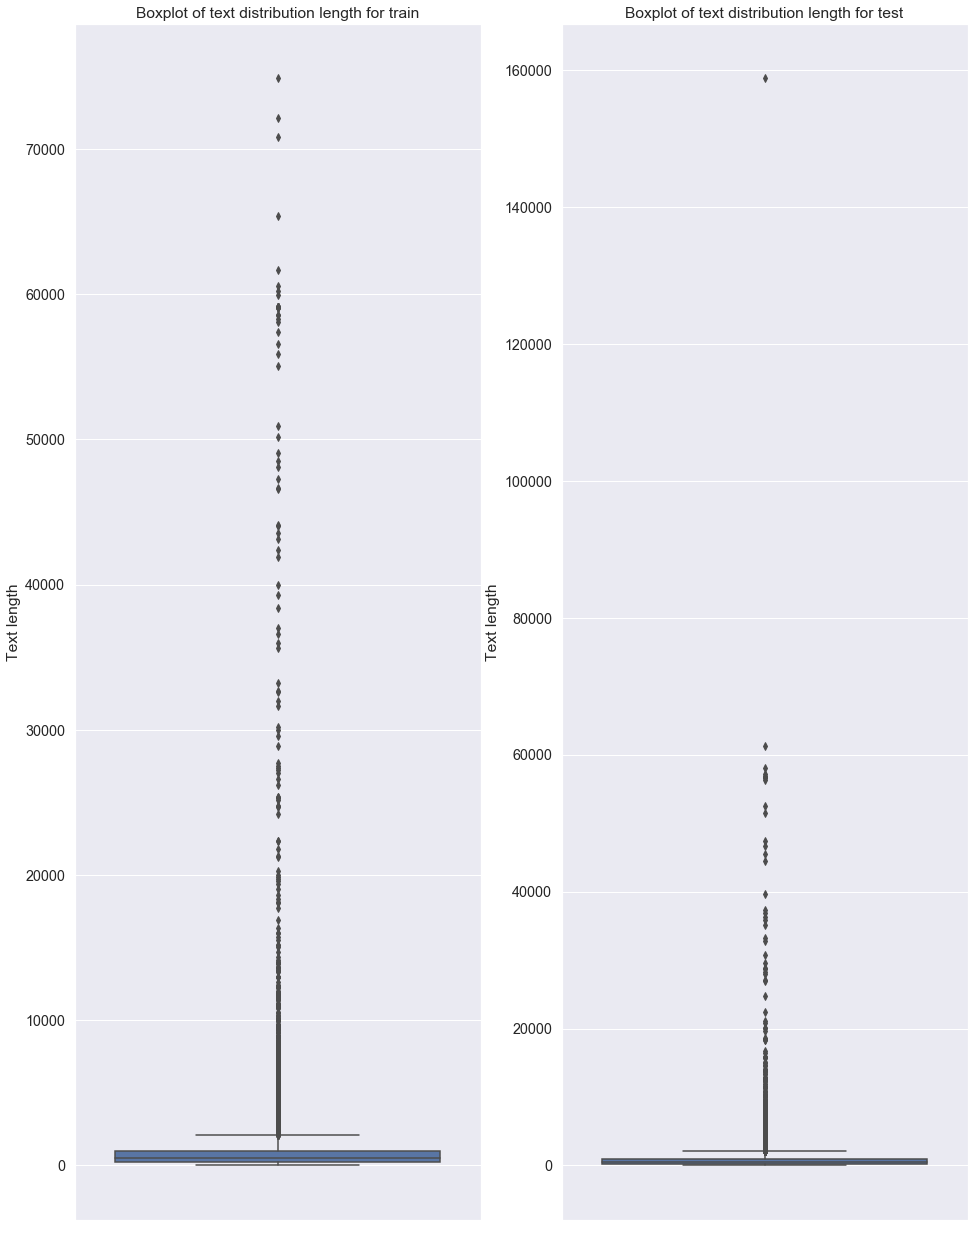

In [1292]:
plt.figure(figsize=(16,22))
plt.subplot(1,2,1)
sns.boxplot(y = df_texts[df_texts.text_type == 'train'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length for train");
plt.subplot(1,2,2)
sns.boxplot(y = df_texts[df_texts.text_type == 'test'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length for test");
plt.show();

Похоже тексты в обучающем датасете чуть более длинные, чем в тестовом.

Также в тестовом датасете есть один достаточно длинный текст.

- Выделим топ-50 слов по всем текстам и построим их гистограмму частот.

In [92]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(tokenizer=tokenize, 
                          stop_words=StopWords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [93]:
%%time
train_top_words = get_top_n_words(train_texts.data, n=150);
test_top_words = get_top_n_words(test_texts.data, n=150);

D:\Programs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'hans', 'helen', 'holly', 'jean', 'jeanne', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
D:\Programs\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Programs\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should prob

Wall time: 4min 45s


Some work with tf-idf vocabulary to get most used word(lowest tf-idf score).

In [1306]:
train_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
train_dict =  dict(sorted(train_dict.items(), key=lambda kv: kv[1]))
# sort in descending order, most freq words first, rare words with big weight in the end

inverse_dict = {}
for k, v in train_dict.items():
    inverse_dict[k] = 1/int(v)
 

In [1310]:
#made only for print
dictlist = []
for key, value in inverse_dict.items():
    temp = [key,value]
    dictlist.append(temp)

[['like', 0.5],
 ['know', 0.5],
 ['time', 0.5],
 ['think', 0.5],
 ['people', 0.5],
 ['make', 0.5],
 ['use', 0.5],
 ['good', 0.5],
 ['way', 0.3333333333333333],
 ['thing', 0.3333333333333333],
 ['year', 0.3333333333333333],
 ['say', 0.3333333333333333],
 ['new', 0.3333333333333333],
 ['want', 0.3333333333333333],
 ['problem', 0.3333333333333333],
 ['work', 0.3333333333333333],
 ['right', 0.3333333333333333],
 ['used', 0.3333333333333333],
 ['thanks', 0.3333333333333333],
 ['really', 0.3333333333333333],
 ['question', 0.3333333333333333],
 ['point', 0.3333333333333333],
 ['come', 0.3333333333333333],
 ['look', 0.3333333333333333],
 ['using', 0.3333333333333333],
 ['help', 0.3333333333333333],
 ['mean', 0.3333333333333333],
 ['going', 0.3333333333333333],
 ['case', 0.3333333333333333],
 ['sure', 0.3333333333333333],
 ['day', 0.3333333333333333],
 ['got', 0.3333333333333333],
 ['let', 0.3333333333333333],
 ['number', 0.3333333333333333],
 ['believe', 0.3333333333333333],
 ['said', 0.333333

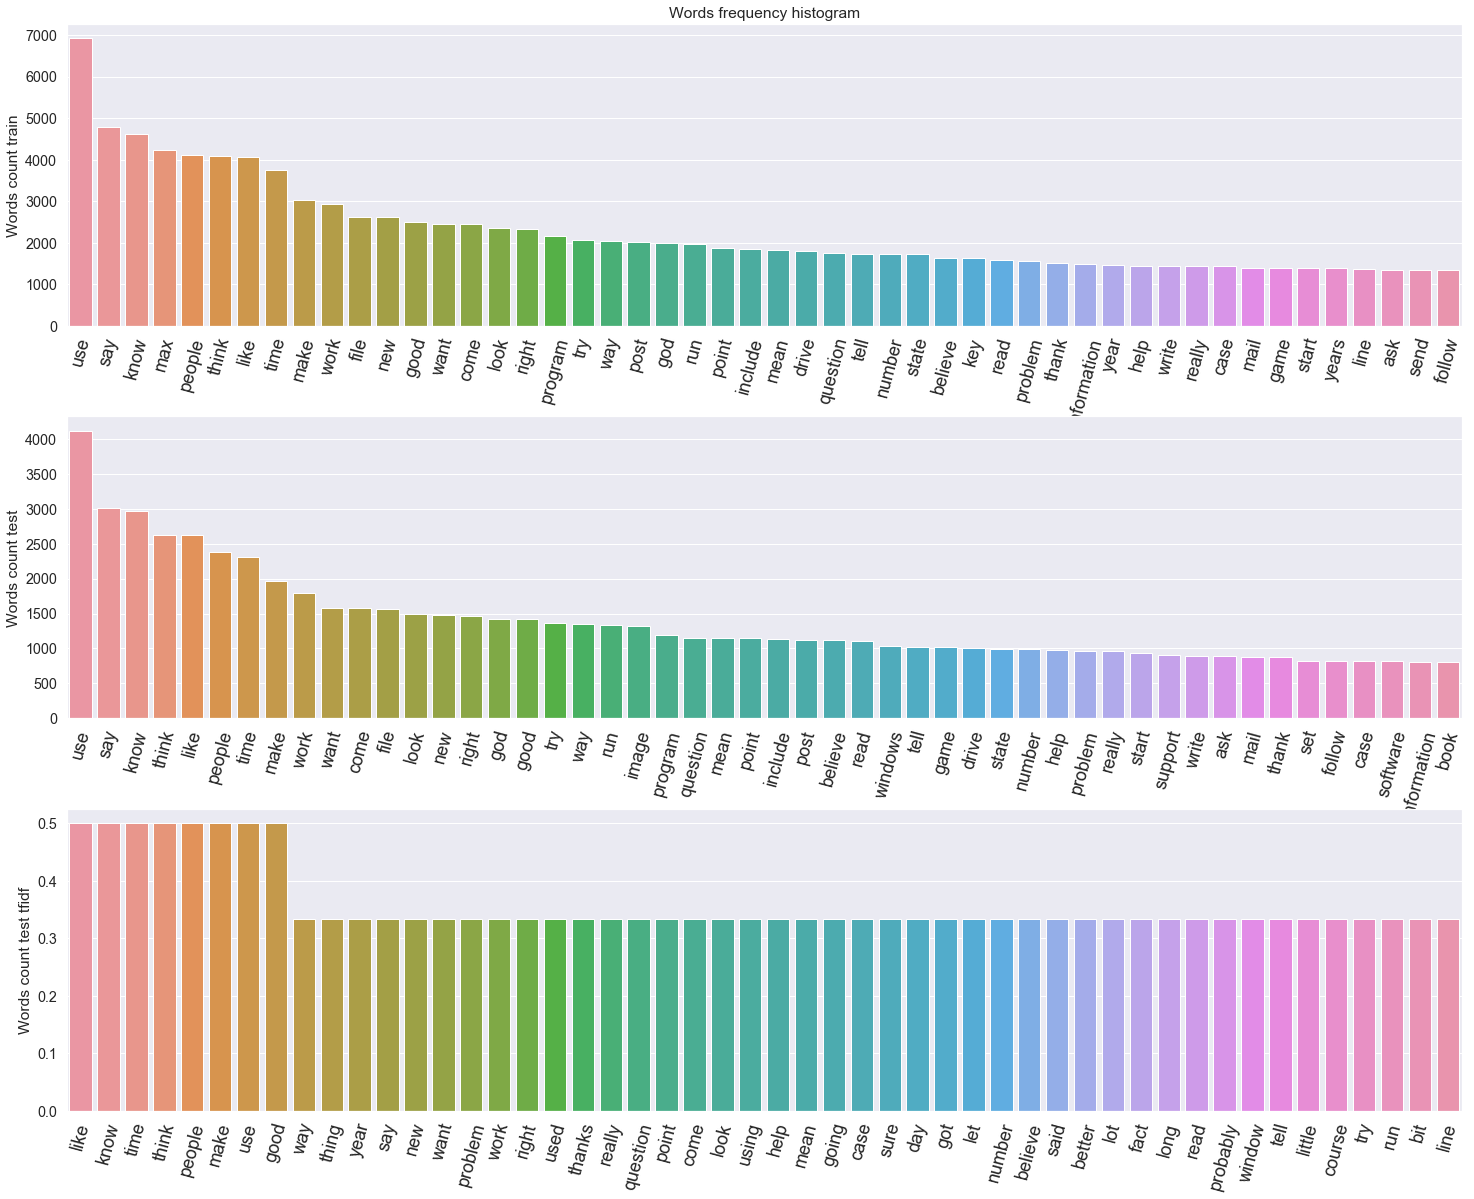

In [1317]:
xs_train = [i[0] for i in train_top_words[:50]]
ys_train = [i[1] for i in train_top_words[:50]]

xs_test = [i[0] for i in test_top_words[:50]]
ys_test = [i[1] for i in test_top_words[:50]]

xs_tfidf = [i[0] for i in dictlist[:50]]
ys_tfidf = [i[1] for i in dictlist[:50]]

plt.figure(figsize=(25,20))
plt.subplot(3,1,1)
sns.barplot(x = xs_train, y = ys_train)
plt.ylabel('Words count train');
plt.title("Words frequency histogram");
plt.xticks(rotation=75,fontsize = 18)
plt.subplots_adjust(hspace=0.3)

plt.subplot(3,1,2)
sns.barplot(x = xs_test, y = ys_test)
plt.ylabel('Words count test');
plt.xticks(rotation=75,fontsize = 18)

plt.subplot(3,1,3)
sns.barplot(x = xs_tfidf, y = ys_tfidf)
plt.ylabel('Words count test tfidf');
plt.xticks(rotation=75,fontsize = 18)
plt.show();

del dictlist

Как видно, часть слов совпадает, также стоит отметить, что подход TFIDF нагядно показывает нормировку часто употребимых слов.

##### Words cloud.

Чтобы более наглядно и красиво визуализировать слова попробуем использовать WordClouds.

In [1318]:
def create_wc(freq_text, n_words):
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=n_words,
            stopwords = StopWords,width=1600, height=800)

    # Generate and plot wordcloud
    plt.figure(figsize =[14,7])
    plt.imshow(wc.generate_from_frequencies(frequencies=freq_text))
    plt.axis('off')
    plt.show()

TF-IDF set

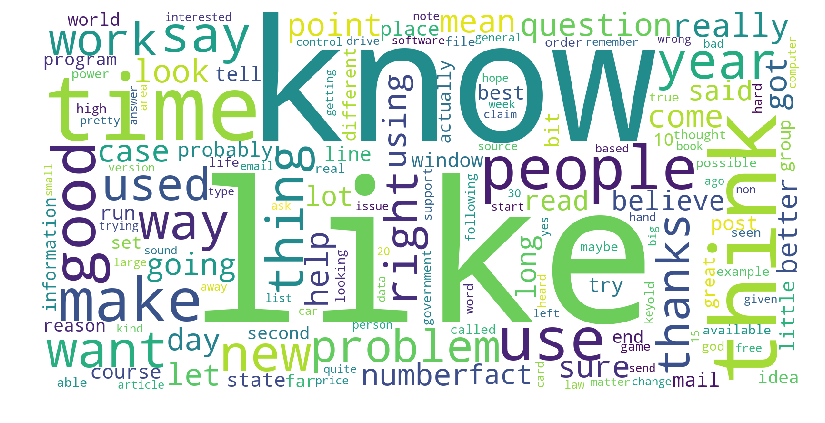

In [1319]:
create_wc(inverse_dict,150)
del inverse_dict, train_dict

Count vectorizer train set

In [1320]:
train_top_words_test = dict(train_top_words)
test_top_words_test = dict(test_top_words)

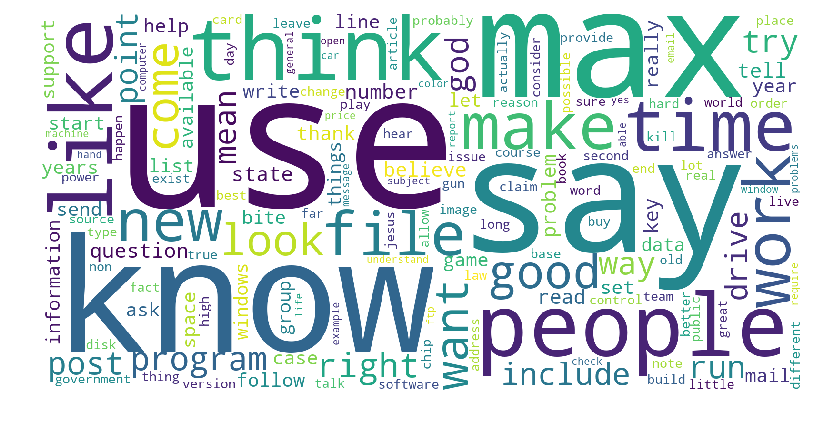

In [1321]:
create_wc(train_top_words_test,150)

Count vectorizer test set

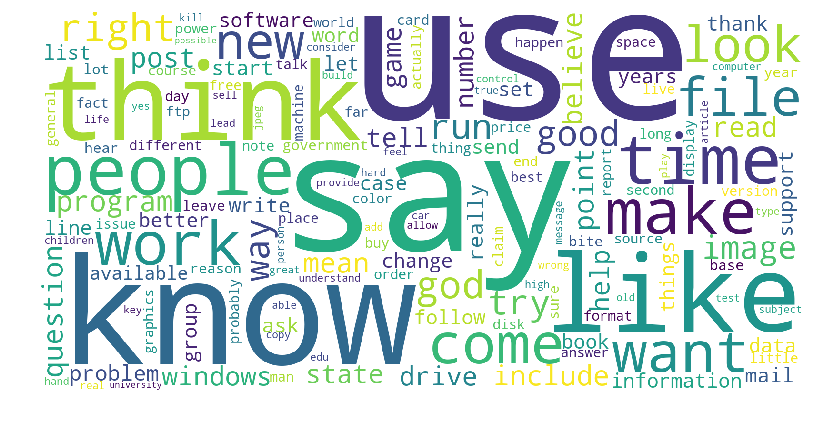

In [1322]:
create_wc(test_top_words_test,150)
del train_top_words_test,test_top_words_test

Dimension reduction and visualization:
TruncatedSVD -> T-SNE or UMAP.

Основная идея подобных техник, применяемая в задачах обучения без учителя, состоит в том, чтобы попробовать восстановить и визуализировать структуры данных, которые могут быть скрыты в них.

Так как алгоритмы визуализации (в частности T-SNE работает достаточно небыстро), то перед этим рекомендуется предварительно сократить размерность.

In [1323]:
svd = TruncatedSVD(n_components=2000, n_iter=15, random_state=seed)#,algorithm='arpack' can get better result,but time...

In [1324]:
%%time
svd.fit(vectorised_train_documents)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 3min 54s


TruncatedSVD(algorithm='randomized', n_components=2000, n_iter=15,
       random_state=321, tol=0.0)

In [1325]:
print(svd.explained_variance_ratio_.sum())

0.5827538168200641


In [1326]:
print(svd.explained_variance_.sum())

0.5777087884643388


In [1327]:
%%time
svd_vect_train_documents = svd.transform(vectorised_train_documents)
svd_vect_test_documents = svd.transform(vectorised_test_documents)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 3.31 s


In [1328]:
svd_vect_train_documents.shape

(10977, 2000)

In [1329]:
svd_vect_test_documents.shape

(7290, 2000)

#### T-SNE Test.

In [1330]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300,learning_rate = 100)
tsne_results = tsne.fit_transform(svd_vect_train_documents)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10977 samples in 1.989s...
[t-SNE] Computed neighbors for 10977 samples in 714.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10977
[t-SNE] Computed conditional probabilities for sample 2000 / 10977
[t-SNE] Computed conditional probabilities for sample 3000 / 10977
[t-SNE] Computed conditional probabilities for sample 4000 / 10977
[t-SNE] Computed conditional probabilities for sample 5000 / 10977
[t-SNE] Computed conditional probabilities for sample 6000 / 10977
[t-SNE] Computed conditional probabilities for sample 7000 / 10977
[t-SNE] Computed conditional probabilities for sample 8000 / 10977
[t-SNE] Computed conditional probabilities for sample 9000 / 10977
[t-SNE] Computed conditional probabilities for sample 10000 / 10977
[t-SNE] Computed conditional probabilities for sample 10977 / 10977
[t-SNE] Mean sigma: 0.284719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.325607
[t-SNE]

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


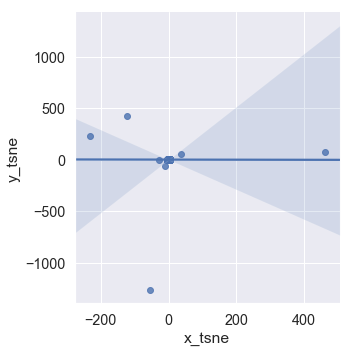

In [1331]:
df_tsne = pd.DataFrame(tsne_results.copy())
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

sns.lmplot(x='x_tsne', y='y_tsne',data = df_tsne)


#### UMAP Tests.

In [1332]:
min_distances = [0.001,0.01,0.1,0.3] #bigger -> scattered
metrics = ['euclidean']#,'minkowski']
n_neighbors = [9]#[7,9,13] 
reducer = umap.UMAP(random_state=seed,n_neighbors=13, min_dist=0.3,metric='minkowski')
reducer

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='minkowski',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=13, negative_sample_rate=5, random_state=321,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

SVD Data.

9 euclidean 0.001


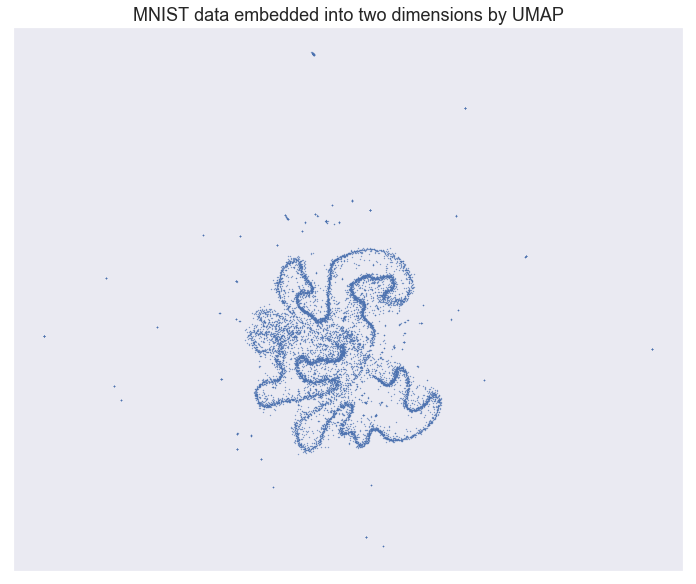

9 euclidean 0.01


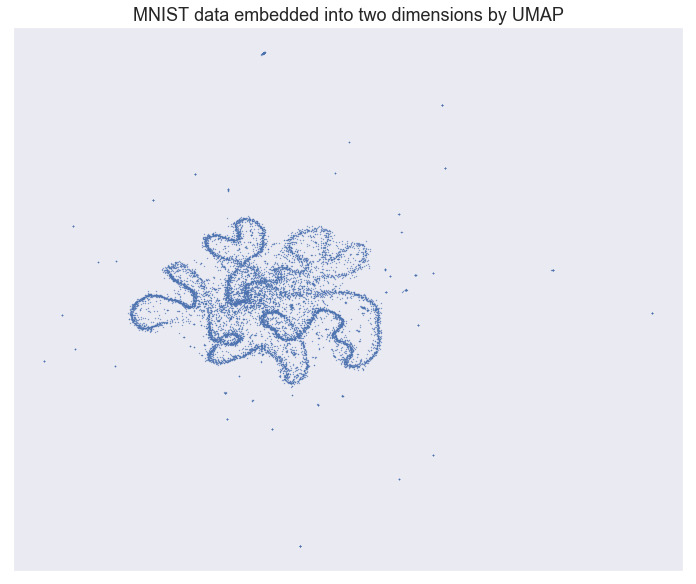

9 euclidean 0.1


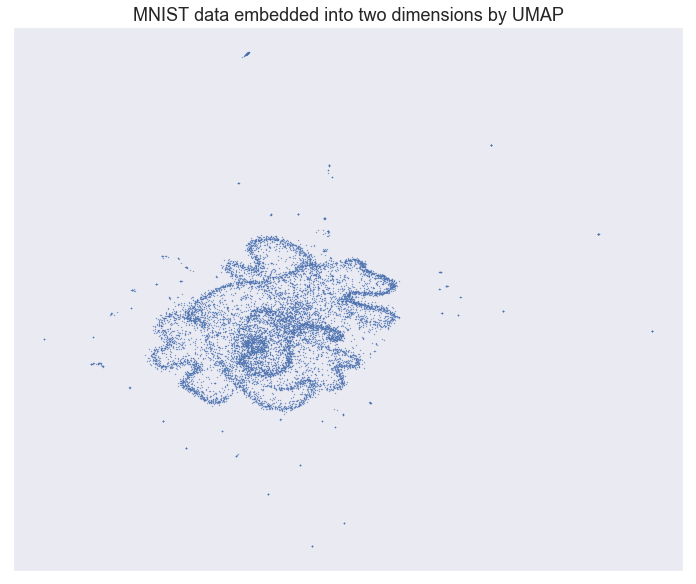

9 euclidean 0.3


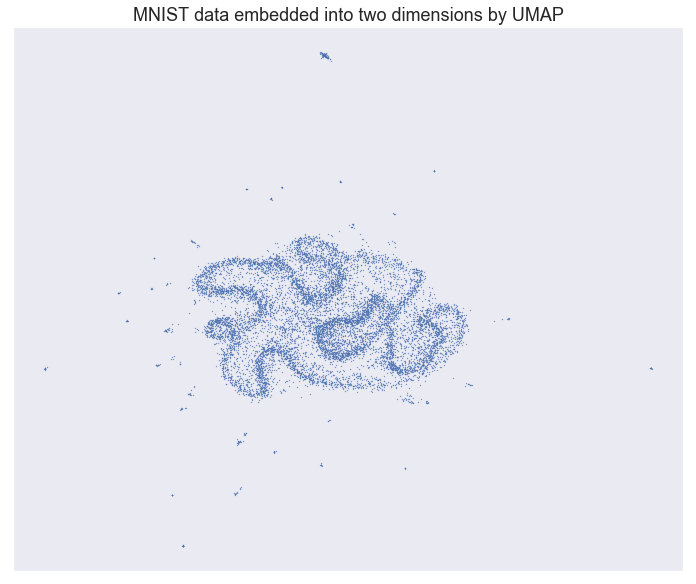

In [114]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(svd_vect_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("SVD data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

TF-IDF Data.
Train Data Example.

9 euclidean 0.001


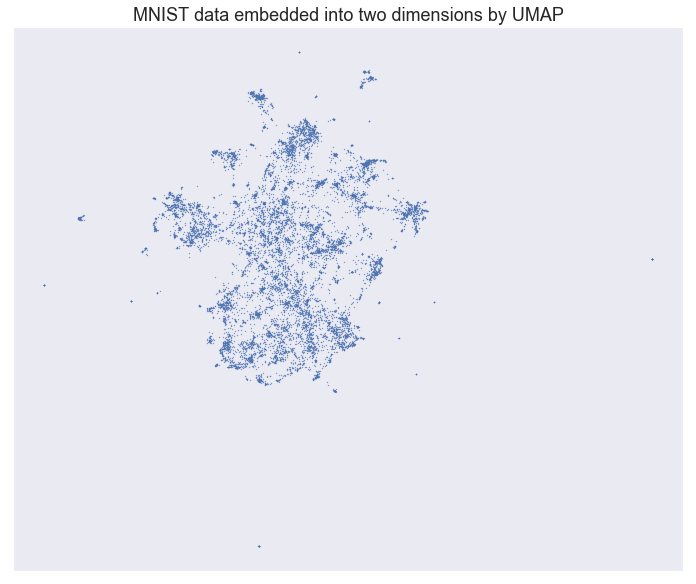

9 euclidean 0.01


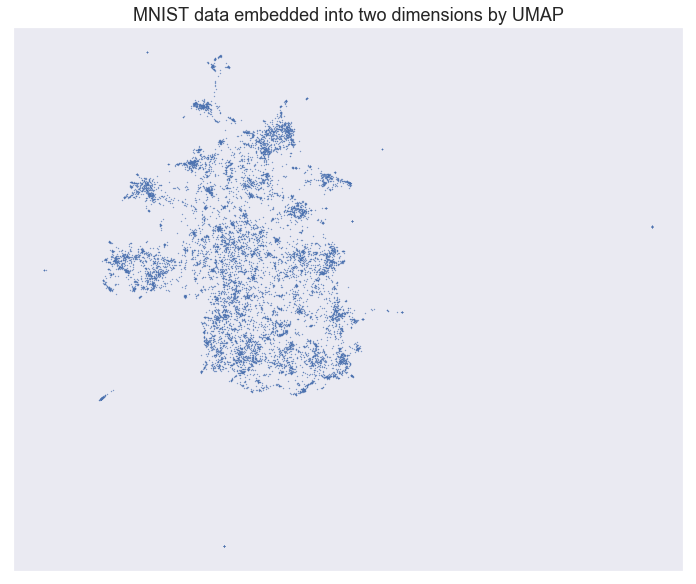

9 euclidean 0.1


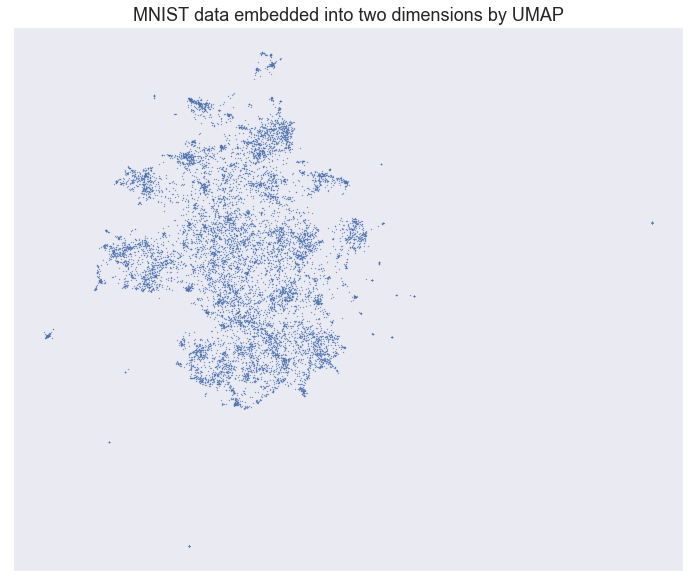

9 euclidean 0.3


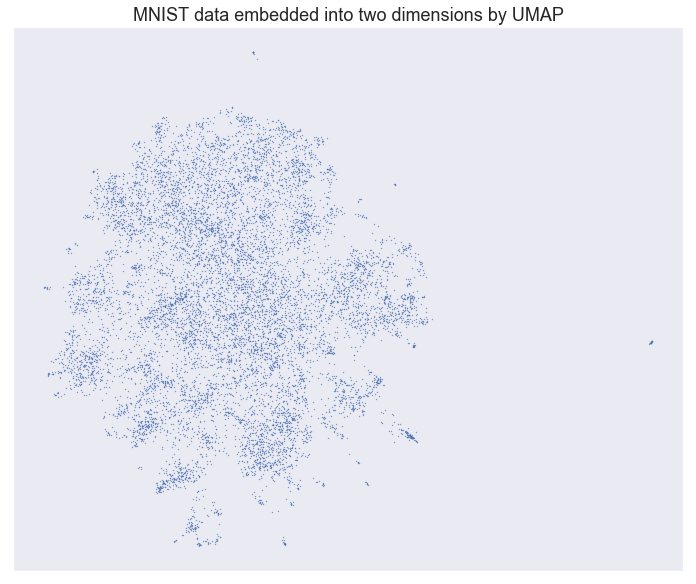

In [1333]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(vectorised_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("TfIDF train data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

На примере графика с данными от TFIDF c параметрам - количество соседеней -  9, метрика - euclidean, минимальная дистанция -  0.01/0.001, можно различить несколько сгруппированных групп точек.

Что, в свою очередь, может говорить о наличии нескольких тем в данных.

#### Kmeans and DBSCAN.

В первую очередь, попробуем использовать алгоритм K-Means для кластеризации данных.

Т.к. при кластеризации осуществляется вычисление расстояний между объектами, то лучше будет выровнять веса полученные при помощи TFIDF.

In [1337]:
ss = StandardScaler(with_mean=False)

ss.fit(vectorised_train_documents)

vectorised_train_documents_scaled = ss.transform(vectorised_train_documents)
vectorised_test_documents_scaled = ss.transform(vectorised_test_documents)

Зададим параметры.

In [1382]:
k_clusters = 7 # Number of Centroids, correspond to amount high level topics
model = KMeans(n_clusters=k_clusters, max_iter=100, 
               n_init=15, n_jobs=-1,
               init = 'random',precompute_distances = 'auto') #init ='k-means++'

In [1383]:
%%time
model.fit(vectorised_train_documents_scaled)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 1min 8s


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=100,
    n_clusters=7, n_init=15, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Для оценки параметров кластеризации воспользуемся функцией, которая будет вычислять несколько метрик сразу.

In [1384]:
def bench_k_means(estimator, name, data, labels,sample_size):
    print(89 * '_')
    print('init\tinertia\t\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

    print('%-5s\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, estimator.inertia_,
             homogeneity_score(labels, estimator.labels_),
             completeness_score(labels, estimator.labels_),
             v_measure_score(labels, estimator.labels_),
             adjusted_rand_score(labels, estimator.labels_),
             adjusted_mutual_info_score(labels,  estimator.labels_,average_method='arithmetic'),
             silhouette_score(data, estimator.labels_,metric='euclidean')#, sample_size=sample_size)
            )
         )

In [1385]:
bench_k_means(model, "kmeans" , vectorised_train_documents_scaled, y_train, k_clusters)

_________________________________________________________________________________________
init	inertia		homo	compl	v-meas	ARI	AMI	silhouette
kmeans	432922605	0.002	0.130	0.005	-0.000	0.003	0.008


In [1386]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


Top terms per cluster:
Cluster 0:
 ole guitar
 addrs uni
 sun certainly ball
 sun certainly
 flaming gas lawrence
 guitar addrs
 guitar addrs uni
 addrs
 addrs uni liverpool
 liverpool university
Cluster 1:
 documentation available
 loaned
 977
 adding additional
 tandy
 jumper pin
 master slave
 cyl
 second drive
 drive know
Cluster 2:
 like
 know
 think
 people
 time
 make
 use
 good
 way
 thing
Cluster 3:
 tanstaafl
 groucho sort grafitti
 internet come close
 internet come
 1968 tanstaafl
 1968 tanstaafl internet
 marxist groucho sort
 edu marxist
 edu marxist groucho
 grafitti paris 1968
Cluster 4:
 feature like
 good hard
 removable medium
 driver software
 drive maybe
 window input
 multiple window input
 display want
 affordable
 silverlining
Cluster 5:
 possibility error
 tran
 wittgenstein
 elaborated
 true certain
 said totally
 human brain
 reason draw
 reason draw conclusion
 evangelical christian
Cluster 6:
 20mb 40mb
 15 20mb
 15 20mb 40mb
 40mb burst
 12mb 20mb burst
 1

In [1410]:
transf = model.transform(vectorised_train_documents_scaled)

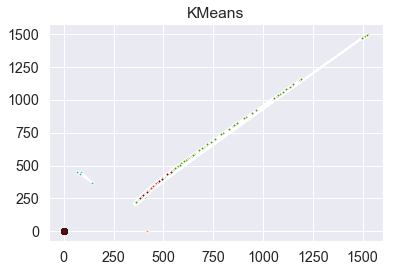

In [1411]:
k_means_labels = model.labels_
k_means_cluster_centers = model.cluster_centers_

X = transf
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#ce3d2b','#800000','#ce3d2b','#800000']

plt.figure()
for k, col in zip(range(k_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

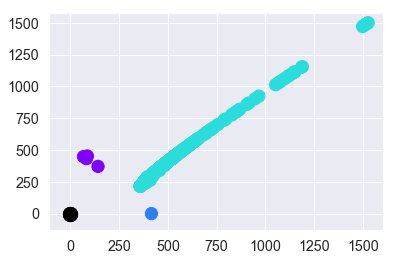

In [1389]:
plt.scatter(transf[:,0],transf[:,1], c=k_means_labels, cmap='rainbow',s=150)

plt.scatter(k_means_cluster_centers[:, 0], k_means_cluster_centers[:, 1], c='black', s=200, alpha=0.5);

#### DBSCAN.

In [1391]:
clusterer = DBSCAN(n_jobs=-1, eps=0.7, metric = 'cosine', min_samples=17)#cosine

#eps=0.7, metric='euclidean', min_samples=5, 

In [1392]:
clusterer
# tune eps, leaf_size, metric?
# nope,because brute only, in case of sparse matrix

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

Здесь, хоть результаты схожие с KMeans, большее количество кластеров и лучшие значения метрик дает неотскелейнный набор данных.

In [1400]:
%%time
#clusterer.fit(vectorised_train_documents_scaled) 
clusterer.fit(vectorised_train_documents)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 7.48 s


DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

In [1401]:
labels = clusterer.labels_
labels_true = y_train

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [1412]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels,average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(vectorised_train_documents_scaled, labels))

Estimated number of clusters: 4
Estimated number of noise points: 10835
Homogeneity: 0.013
Completeness: 0.267
V-measure: 0.025
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.023
Silhouette Coefficient: -0.124


In [1413]:
core_samples_mask = np.zeros_like(clusterer.labels_, dtype=bool)
core_samples_mask[clusterer.core_sample_indices_] = True

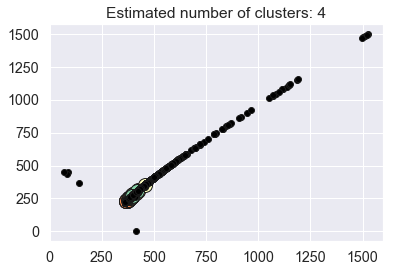

In [1414]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

#### Topic modelling.

#### LDA from Gensim.

Основной идеей тематического моделирования является попытка определить по набору слов, к какой теме они относятся.

Основными понятиями в данной области является тема - набор слов(н-грам) и документ, описывающий распределение документов над темами.

Проинизиализурем модель LDA из пакета Gensim.

In [1415]:
%%time
num_topics=5 
passes=20

corpus = matutils.Sparse2Corpus(vectorised_train_documents.T)
dictionary = Dictionary.from_corpus(corpus,
                                    dict([(i, s) for i, s in enumerate(vocab)]))

vocab = vectorizer.get_feature_names()
lda = LdaModel(corpus, num_topics=num_topics,
         passes=passes,
         id2word=dict([(i, s) for i, s in enumerate(vocab)]))

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 1min 46s


In [135]:
def print_topics(lda, vocab, n=10):
    """ Print the top words for each topic. """
    topics = lda.print_topics(num_topics=-1, num_words=n)
    for topic in topics:
        print(topic)

Выведем топ слов по заданному количеству топиков.

In [1]:
print_topics(lda, vocab, 7)

NameError: name 'print_topics' is not defined

При помощи pyLDAvis визуализируем данные:

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

Как видно, наблюдается несколько топиков, из которых можно выделить:


Заключение:

- написать про генсим лемматизатор
- про схожесть топика с топом слов в tf idf.

#### difference between clustering, dimension reduction and topic modeling.

Кластеризация - 

Сокращение размерности - 

Тематическое моделирование - процесс одновременной кластеризации текстов и слов по одному и тому же множеству кластеров, называемых темами. 

Обычно выполняется нечёткая кластеризация, когда документ/слово может принадлежать нескольким темам.

По сути, мы пытаемся по tf-idf скору построить вероятностное распределение на множестве тем.

!!! to read !!!

- http://www.machinelearning.ru/wiki/images/f/f7/VMK_NLP_TM.pdf

- http://www.ispras.ru/proceedings/docs/2012/23/isp_23_2012_215.pdf

- https://iksinc.online/2016/05/16/topic-modeling-and-document-clustering-whats-the-difference/

- https://people.cs.umass.edu/~brenocon/inlp2014/lectures/22-tm.pdf

In [143]:
print test

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(test)? (<ipython-input-143-f95b3ffdade0>, line 1)

#### Appendix

Функция удаления пустых строк в numpy sparce matrix.

In [ ]:
def remove_zero_tf_idf(Xtr, min_tfidf=0.04):
    D = Xtr.toarray() # convert to dense if you want
    D = Xtr
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0) # find features that are 0 in all documents
    D = np.delete(D, np.where(tfidf_means == 0)[0], axis=1) # delete them from the matrix
    return D

In [ ]:
def show_most_informative_features(vectorizer, clf, n=20):
    aa = []
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t% 15s\t\t%.4f\t% 15s" % (coef_1, fn_1, coef_2, fn_2))
        aa.append(fn_1)
        
    #return aa

In [ ]:
show_most_informative_features(vectorizer, clf, 10)

from word cloud tests

In [95]:
'''indices = np.argsort(vectorizer.idf_)[::-1] #
features = vectorizer.get_feature_names()
top_n = 15
top_features = [features[i] for i in indices[:top_n]]
print (top_features)''';

In [96]:
'''from collections import defaultdict

features_by_gram = defaultdict(list)
for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))

top_n = 15

for gram, features in features_by_gram.items():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print ('{}-gram top:'.format(gram), top_features)''';

 The higher the numerical weight value, the rarer the term. The smaller the weight, the more common the term.

In [97]:
'''#test block
indices = np.argsort(vectorizer.idf_)[::-1] # The inverse document frequency (IDF) vector, -1 if we want biggest first tf-idf weight
features = vectorizer.get_feature_names() #



np.sort(vectorizer.idf_)[::1]

indices

features[1604549]

#voc_dict = dict(zip(features,indices))
voc_dict = [features[i] for i in indices]
#voc_dict''';

In [98]:
'''from itertools import islice

def take(n, iterable):
    #"Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

n_items = take(5, gg.items())

n_items''';

GENSIM LDA.

In [139]:
def gensim_output(modelfile, corpusfile, dictionaryfile): 
    """Displaying gensim topic models"""
    ## Load files from "gensim_modeling"
    corpus = corpora.MmCorpus(corpusfile)
    dictionary = corpora.Dictionary.load(dictionaryfile) # for pyLDAvis
    myldamodel = models.ldamodel.LdaModel.load(modelfile)    

    ## Interactive visualisation
    import pyLDAvis.gensim
    vis = pyLDAvis.gensim.prepare(myldamodel, corpus, dictionary)
    pyLDAvis.display(vis)

In [140]:
#gensim_output(lda, vec, dictionary)

In [144]:
#pyLDAvis.gensim.prepare(lda, corpus, dictionary) #working

In [142]:
#pyLDAvis.sklearn.prepare(lda, corpus, vectorizer)